In [2]:
# Seed value
seed_value= 7

# Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow
tensorflow.random.set_seed(seed_value)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tensorflow.config.set_visible_devices([], 'GPU')

tensorflow.compat.v1.disable_v2_behavior()
import pandas as pd
from tensorflow.compat.v1.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow_addons.layers import MultiHeadAttention
from tensorflow.compat.v1.keras.preprocessing.text import Tokenizer
from tensorflow.compat.v1.keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.initializers import Constant
from tensorflow.compat.v1.keras.layers import Layer, Convolution1D, Embedding, Dense, Flatten, MaxPooling1D, Input, Bidirectional, LSTM, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.compat.v1.keras.callbacks import EarlyStopping
import shap

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def run(task, model_type, i):
    
    ### Dataset selection
    
    df = pd.read_csv('data/geo_microblog.csv')
    df = df[df.sentiment != 1]
    df.sentiment.replace(2, 1, inplace=True) # neutral

    ### Text processing
    
    # prepare tokenizer
    
    t = Tokenizer()
    t.fit_on_texts(df['text'])
    vocab_size = len(t.word_index) + 1
    
    # integer encode the documents
    
    encoded_docs = t.texts_to_sequences(df['text'])
    txtlen = 30
    loclen = 0
    
    # pad documents to a max length 
    
    padded_docs = pad_sequences(encoded_docs, txtlen, padding='post')

    ### Prepare train and test set
    
    x_train, x_test, y_train, y_test = train_test_split(padded_docs, df['sentiment'], test_size=0.3, random_state=100)
    
    ### Pretrained word embedding

    vector_dimension = 200
    
    embedding_matrix = np.load('variable/microblog_binary_embedding_matrix.npy')

    ### Deep Learning model
    
    input_dimension = txtlen+loclen
    inputs = Input(shape=(input_dimension,))
    embedding_layer = Embedding(vocab_size, vector_dimension, embeddings_initializer=Constant(embedding_matrix), input_length=input_dimension)(inputs)
    
    if model_type == "CNN":
        # CNN
        convolution_first = Convolution1D(filters=100, kernel_size=5, activation='relu')(embedding_layer)
        convolution_second = Convolution1D(filters=100, kernel_size=4, activation='relu')(convolution_first)
        convolution_third = Convolution1D(filters=100, kernel_size=3, activation='relu')(convolution_second)
        pooling_max = MaxPooling1D(pool_size=2)(convolution_third)
        flatten_layer = Flatten()(pooling_max)
        dense = Dense(20, activation="relu")(flatten_layer)
        outputs = Dense(units=1, activation='sigmoid')(dense)
    
    if model_type == "BiLSTM":
        ### BiLSTM
        lstm_first = Bidirectional(LSTM(units=100))(embedding_layer)
        dense = Dense(20, activation="relu")(lstm_first)
        outputs = Dense(1, activation='sigmoid')(dense)
      
    if model_type == "Transformer":
        ### Transformer
        num_heads = 2  # Number of attention heads
        ff_dim = 32  # Hidden layer size in feed forward network inside transformer
        
        embedding_layer_weighted = TokenAndPositionEmbedding(input_dimension, vocab_size, vector_dimension, Constant(embedding_matrix))
        x = embedding_layer_weighted(inputs)
        
        transformer_block = TransformerBlock(vector_dimension, num_heads, ff_dim)
        x = transformer_block(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(20, activation="relu")(x)
        outputs = Dense(1, activation='sigmoid')(x)
    
    # build model
    
    model = Model(inputs, outputs)
    
    # compile model
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.load_weights(f"saved/{task}/1_text_only/{model_type}/{task}_location_False_{model_type}_{i}.h5")
    
    #early_stopping_monitor = EarlyStopping(patience=3) #patience: epochs the model can go without improving before we stop training

    #history = model.fit(x_train, y_train, validation_split=0.3, epochs=20, callbacks=[early_stopping_monitor], verbose=1) 
    
    # evaluate model
    
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    
    return model, loss, accuracy, x_train, x_test

In [4]:
### Run 

task = "binary"
model_type = "CNN"
i = 0

df_new = pd.DataFrame(columns=["accuracy", "loss"])

model, loss, accuracy, x_train, x_test= run(task, model_type, i)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
accuracy

0.82501316

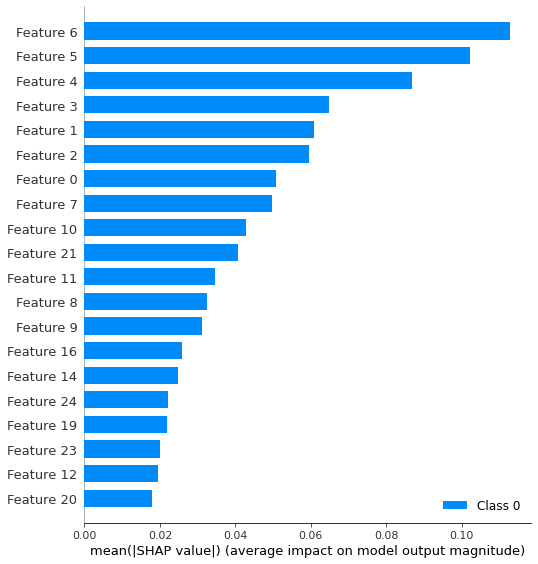

In [23]:
X_train_sample = shap.sample(x_train, 100)
X_test_sample = shap.sample(x_test, 20)
explainer = shap.DeepExplainer(model, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values, X_test_sample)